## For batch analysis of hybrid perovskite TEM/STEM image data

Aims:
- Batch FFT images
- Save FFTs with overlaid spacings for different polytypes of FAPI & PbI2

In [1]:
%matplotlib inline
import numpy as np
#import h5py
#import json
import matplotlib.pyplot as plt
import hyperspy.api as hs
#import os
#import pyxem as pxm
#import logging
#import py4DSTEM
import pandas as pd
import gc

In [7]:
############################################################################################################################
## File locations:
############################################################################################################################


############################################################################################################################
## Example data for Sample 1 (MACL)
############################################################################################################################

f_path = 'D://ePSIC//RAW//removed_path//'

n_start = 142
n_end = 216

n = n_end-n_start
n = np.linspace(n_start, n_end, n+1)
f_numbers = [int(i) for i in n]

f_names = ['OneView_500kX_0' + str(i) + '.dm3' for i in f_numbers]
title = ['Removed_name     ' + i for i in f_names]           

save_path = 'C://Users//sheader//Documents//Data_Analysis//removed_path//ePSIC_data//'
save_title = ['removed_path//removed_name_OneView_500kX_0' + str(i)  for i in f_numbers]


############################################################################################################################
## End
############################################################################################################################



f = [f_path + i for i in f_names]
save_name = [save_path + save_title[i] for i in range(0,len(f_names))]

# f

In [3]:
############################################################################################################################
## Spacings
############################################################################################################################
## Spacings for cubic FAPI and PbI2 polytypes are in Excel documents, themselves pulled from simulations performed with 
## CrystalMaker and CrystalDiffract. 
############################################################################################################################

spacings_file = 'ePSIC_data//spacings.xlsx'

a_fapi = pd.read_excel(spacings_file, 'FAPI_Atomic_Coordinates')

pbi2_2H = pd.read_excel(spacings_file, 'PbI2_2H')

pbi2_4H = pd.read_excel(spacings_file, 'PbI2_4H')

pbi2_6H = pd.read_excel(spacings_file, 'PbI2_6H')

pbi2_3R = pd.read_excel(spacings_file, 'PbI2_3R')

all_phases = pd.concat([a_fapi, pbi2_2H, pbi2_4H, pbi2_6H, pbi2_3R])

# A dataframe with all the FAPI and PbI2 polytypes:
all_phases 

# Columns are Miller indices, plane spacing, 1/plane spacing, arb. intensity, fractional intensity, quantum numbers.

,Name,h,k,l,d,1/d,Int,Frac_int,m,N,Lp
0,FAPI,0,0,1,6.337570,0.157789,0.002249,1.000000,2,1,505.401676
1,FAPI,0,0,2,3.168785,0.315578,0.001785,0.793590,2,4,252.700838
2,FAPI,0,1,1,4.455683,0.224432,0.001066,0.473932,2,2,355.326966
3,FAPI,0,1,-1,4.455683,0.224432,0.001066,0.473932,2,2,355.326966
4,FAPI,0,1,0,6.265620,0.159601,0.000794,0.352796,2,1,499.663885
...,...,...,...,...,...,...,...,...,...,...,...
29,3R,1,1,12,1.422491,0.702992,0.000272,0.158492,12,146,113.439293
30,3R,2,1,-5,1.396621,0.716014,0.000040,0.023469,12,30,111.376249
31,3R,2,0,11,1.396564,0.716043,0.000020,0.011733,6,125,111.371671
32,3R,2,1,7,1.333808,0.749733,0.000036,0.020939,12,54,106.367089


In [8]:
############################################################################################################################
## Plot FFTs
############################################################################################################################

## Diffraction calibration set by user:

diffraction_calibration = 0.011 

raw_diffraction_calibration = 0.0097305 # Was 0.0097305 from raw data. 



d = [[] for i in range(0,len(f))]
d_fft = [[] for i in range(0,len(f))]
d_fft_cropped = [[] for i in range(0,len(f))]

center = diffraction_calibration*2048/2


m = [[] for i in range(0,len(f))]

# From spacings dataframe
r=all_phases['d']
r = [20/(i) for i in r] # Convert real spacing to reciprocal space

# Colours for diffraction ring overlay on FFT
c = 'r' * len(a_fapi) + 'b' * len(pbi2_2H) + 'g' * len(pbi2_4H) + 'w' *len(pbi2_6H) + 'y' *len(pbi2_3R)

# Make ring overlays transparent
alphas = all_phases['Frac_int']
alphas = [i*1 for i in alphas]
alphas = [0.2 if i<0.2 else i for i in alphas]

# Add diffraction ring overlays
for i in range(0,len(f)):
    for j in range(0,len(r)):
    
        m[i].append(hs.plot.markers.ellipse(x=center, y=center, width=r[j], height=r[j],
                                 edgecolor=c[j], fill=False, linewidth=0.5, alpha=0.5)) #alpha=alphas[j])


# Do for all image files

for i in range(0,len(f)):
    
    d[i] = hs.load(f[i], lazy=False)
    d_fft[i] = d[i].fft(shift=True) # shift=True centers the FFT
    
    d_fft_cropped[i] = hs.signals.Signal2D(np.log(np.abs(d_fft[i].data[1024:3072, 1024:3072]))) # Crop FFT to central region
    
    #d_fft_cropped[i].set_signal_type('electron_diffraction')
    
    # Set axes:
    d_fft_cropped[i].axes_manager[0].units = 'nm^-1'
    d_fft_cropped[i].axes_manager[1].units = 'nm^-1'
    d_fft_cropped[i].axes_manager[0].scale = diffraction_calibration
    d_fft_cropped[i].axes_manager[1].scale = diffraction_calibration
    d_fft_cropped[i].beam_energy = 200

    # Generate plots:
    d_fft_cropped[i].plot(vmin='10th', vmax='99th', colorbar=False, axes_off=True, title=title[i], scalebar=False)
    d_fft_cropped[i].add_marker(m[i], permanent=True)

    # Save plots:
    plt.savefig(save_name[i]+'.png', format='png', dpi=250)
    
    plt.close()
    gc.collect() 
    

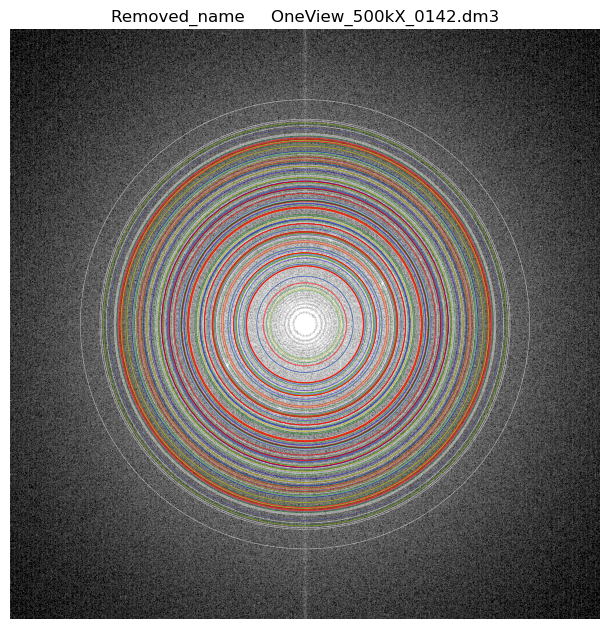

In [9]:
## Example plot

d_fft_cropped[0].plot(vmin='10th', vmax='99th', colorbar=False, axes_off=True, title=title[0], scalebar=False)


## Percentage error on calibration

In [6]:
err = 100*(diffraction_calibration-raw_diffraction_calibration)/raw_diffraction_calibration

print('Percentage error is about ' + str(err) + '%.')

Percentage error is about 13.046606032577975%.
